## TOC:
* [Unzip data](#first-bullet)
* [Swath Selection](#second-bullet)
* [Calibration and save](#third-bullet)

In [1]:
import zipfile
import os
import numpy as np
import re
import xml.etree.ElementTree as etree
import rasterio
from rasterio.enums import Resampling
from natsort import natsorted
import imageio
from PIL import Image
import matplotlib.pyplot as plt
import scipy.io
import copy
from pathlib import Path

## Unzip data <a class="anchor" id="first-bullet"></a>

In [2]:
#Zip Data Path
path='/hdd/Sentinel_1/Test/'
#Swath Selection,example 001
swath='046'

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

zipList= natural_sort([file for file in os.listdir(path) if file.endswith('.zip')])
print('Zip List')
print(np.array(zipList).T)

for file in zipList:   # get the list of files # if it is a zipfile, extract it
    print("Doing ",file)
    with zipfile.ZipFile(path+file) as item: # treat the file as a zip
        item.extractall(path+'SAFE/')  # extract it in the working directory

print('Ended')


['S1B_WV_SLC__1SSV_20200608T090917_20200608T092019_021940_029A33_1D88.zip'
 'S1B_WV_SLC__1SSV_20200620T090918_20200620T092020_022115_029F84_7BA9.zip']
Doing  S1B_WV_SLC__1SSV_20200608T090917_20200608T092019_021940_029A33_1D88.zip
Doing  S1B_WV_SLC__1SSV_20200620T090918_20200620T092020_022115_029F84_7BA9.zip
Ended


## Swath selection<a class="anchor" id="second-bullet"></a>

In [5]:
safeList= natural_sort([file for file in os.listdir(path+'SAFE/') if file.endswith('.SAFE')])
slcList=[]

for file in safeList:   # get the list of files in the folder
    tiffVignette=[tifile for tifile in os.listdir(path+'SAFE/'+file+'/measurement/') if tifile.endswith(swath +'.tiff')]# get the list of tiff files in the measurement folder
    for slc in tiffVignette:
        slcList.append(str(file) + '/measurement/' + str(slc))

print(np.array(slcList).T)
print('Ended')

['S1B_WV_SLC__1SSV_20200608T090917_20200608T092019_021940_029A33_1D88.SAFE/measurement/s1b-wv2-slc-vv-20200608t092017-20200608t092019-021940-029a33-046.tiff'
 'S1B_WV_SLC__1SSV_20200620T090918_20200620T092020_022115_029F84_7BA9.SAFE/measurement/s1b-wv2-slc-vv-20200620t092017-20200620t092020-022115-029f84-046.tiff']
Ended


## Calibration and save <a class="anchor" id="third-bullet"></a>

SLC number 0
S1B_WV_SLC__1SSV_20200608T090917_20200608T092019_021940_029A33_1D88.SAFE/measurement/s1b-wv2-slc-vv-20200608t092017-20200608t092019-021940-029a33-046.tiff
S1B_WV_SLC__1SSV_20200608T090917_20200608T092019_021940_029A33_1D88.SAFE/annotation/calibration/calibration-s1b-wv2-slc-vv-20200608t092017-20200608t092019-021940-029a33-046.xml


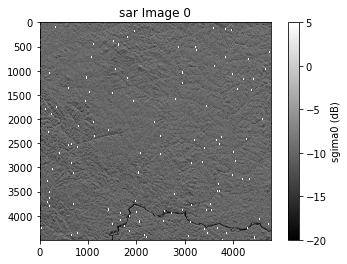

SLC number 1
S1B_WV_SLC__1SSV_20200620T090918_20200620T092020_022115_029F84_7BA9.SAFE/measurement/s1b-wv2-slc-vv-20200620t092017-20200620t092020-022115-029f84-046.tiff
S1B_WV_SLC__1SSV_20200620T090918_20200620T092020_022115_029F84_7BA9.SAFE/annotation/calibration/calibration-s1b-wv2-slc-vv-20200620t092017-20200620t092020-022115-029f84-046.xml


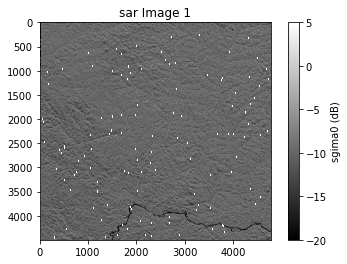

Ended


In [19]:
slcList=natsorted(slcList)
calibList=copy.deepcopy(slcList);
for n in range(0,len(slcList)):
    calibList[n]='calibration-'+slcList[n]
    calibList[n]=slcList[n].replace('measurement/','annotation/calibration/calibration-')
    calibList[n]=calibList[n].replace('.tiff','.xml')
    print('SLC number '+str(n))
    print(slcList[n])
    print(calibList[n])
    fp1 = path+'SAFE/' + slcList[n]
    img1 = rasterio.open(fp1)
    sarImage=(img1.read(1)).T

    RasterWidth=img1.width
    RasterHeight=img1.height
    
    with open(path+'SAFE/'+calibList[n], 'r') as xml_file:
        xml_tree = etree.parse(xml_file)
    root=xml_tree.getroot()

    # READ Pixel 
    PixelArray=[]
    for child in root.findall('calibrationVectorList'):
        for calibVec in child.findall('calibrationVector'):
            for pixel in (calibVec.findall('pixel')):
                (PixelArray.append((pixel.text).split()))
    PixelArray=np.array(PixelArray)  

    # READ sigmaNought
    sigmaNoughtArray=[]
    for child in root.findall('calibrationVectorList'):
        for calibVec in child.findall('calibrationVector'):
            for pixel in (calibVec.findall('sigmaNought')):
                (sigmaNoughtArray.append(((pixel.text).split())))
    sigmaNoughtArray=np.float32(np.array(sigmaNoughtArray))     
    
    # SAVE CALIB ARRAYS AS TIF (This part has to be checked)

    upscale_factorx=(RasterWidth)/(sigmaNoughtArray.shape[0]) # scaling in x (targetNumberPixel/LowResPixel)
    upscale_factory=(RasterHeight)/(sigmaNoughtArray.shape[1])  # scaling in y (targetNumberPixel/LowResPixel)
    Path(path+"SigmaNought").mkdir(parents=True, exist_ok=True)
    imageio.imwrite(path+'SigmaNought/sigmaNoughtArray_' + str (n) +'.tif', sigmaNoughtArray)

    # RESAMPLE
    
    with rasterio.open(path+'SigmaNought/sigmaNoughtArray_' + str (n) +'.tif') as dataset:

        # resample data to target shape
        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * upscale_factorx),
                int(dataset.width * upscale_factory)
            ),
            resampling=Resampling.bilinear
        )

        # scale image transform
        transform = dataset.transform * dataset.transform.scale(
            (dataset.width / data.shape[-1]),
            (dataset.height / data.shape[-2])
        )

    sigmaNoughtArrayResampled=(data)
    lut_calibration=sigmaNoughtArrayResampled[0,:,:]
    np.argwhere(np.isnan(sarImage))
    
    
    # CALIBRATE AND SAVE
    Path(path+"Result").mkdir(parents=True, exist_ok=True)
    sarImage[abs(sarImage)==0]='nan'
    sigma0=np.abs(sarImage)/lut_calibration
    mdic = {"sarImage": sarImage}
    scipy.io.savemat(path+'Result/sarImage_' + str(n) + '.mat', mdic)
    mdic = {"sigma0": sigma0}
    scipy.io.savemat(path+'Result/sigma0_' + str(n) + '.mat', mdic)
    fig = plt.figure()
    plt.imshow((20*np.log10(sigma0)), cmap='gray')
    cbar=plt.colorbar()
    cbar.set_label('sgima0 (dB)')
    plt.title('sar Image ' + str(n))
    plt.clim(-20,5)
    plt.show()
    
print('Ended')